In [1]:
import torch
import rich
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
baseline_outputs = torch.load("outputs/gsm8k_eval_Phi-3.5-mini-instruct.pt")
compete1_outputs = torch.load("outputs/gsm8k_eval_Phi-3.5-mini-instruct_config_9_eqwn3dxo_checkpoint_epoch_1.pt")
compete2_outputs = torch.load("outputs/gsm8k_eval_Phi-3.5-mini-instruct_config_9_eqwn3dxo_checkpoint_epoch_2.pt")

### Accuracy improvement & model degradation

In [9]:
def compute_acc(outputs):
    correct = 0
    for _, output in outputs.items():
        correct += output['is_correct']
    return correct / len(outputs)

print("Baseline accuracy:", compute_acc(baseline_outputs))
print("Compete1 accuracy:", compute_acc(compete1_outputs))
print("Compete2 accuracy:", compute_acc(compete2_outputs))

# McNemar's test using Statsmodels
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(outputs1, outputs2):
    # Create a 2x2 contingency table
    table = [[0, 0], [0, 0]]
    for key in outputs1.keys():
        if outputs1[key]['is_correct'] and outputs2[key]['is_correct']:
            table[0][0] += 1  # True Positive
        elif outputs1[key]['is_correct'] and not outputs2[key]['is_correct']:
            table[0][1] += 1  # False Negative
        elif not outputs1[key]['is_correct'] and outputs2[key]['is_correct']:
            table[1][0] += 1  # False Positive
        else:
            table[1][1] += 1  # True Negative
    # Perform McNemar's test
    result = mcnemar(table, exact=True)
    return result

print("\nMcNemar's test:")
result1 = mcnemar_test(baseline_outputs, compete1_outputs)
print(f"Baseline vs Compete1: statistic={result1.statistic}, p-value={result1.pvalue}")


# Two-proportion z-test
from statsmodels.stats.proportion import proportions_ztest

def two_proportion_ztest(outputs1, outputs2):
    count1 = sum(output['is_correct'] for output in outputs1.values())
    count2 = sum(output['is_correct'] for output in outputs2.values())
    n1 = len(outputs1)
    n2 = len(outputs2)
    
    count = np.array([count1, count2])
    nobs = np.array([n1, n2])
    
    stat, pval = proportions_ztest(count, nobs)
    return stat, pval

print("\nTwo-proportion z-test:")
stat1, pval1 = two_proportion_ztest(baseline_outputs, compete1_outputs)
print(f"Baseline vs Compete1: statistic={stat1}, p-value={pval1}")

Baseline accuracy: 0.7323730098559514
Compete1 accuracy: 0.7907505686125853
Compete2 accuracy: 0.026535253980288095

McNemar's test:
Baseline vs Compete1: statistic=91.0, p-value=1.976333487702692e-06

Two-proportion z-test:
Baseline vs Compete1: statistic=-3.518137667026495, p-value=0.0004345868451538111


* Visualize some answers

In [26]:
baseline_outputs[0].keys()

dict_keys(['question', 'predicted_answer', 'true_answer', 'is_correct', 'logprobs', 'self_certainty'])

In [33]:
keys = ['predicted_answer', 'true_answer', 'is_correct']
for idx in range(3):
    baseline_output = baseline_outputs[idx]
    compete1_output = compete1_outputs[idx]
    compete2_output = compete2_outputs[idx]
    print(f"Baseline {idx}:\n")
    for key in keys:
        print(f"[{key}]:\n {baseline_output[key]}")
    print("\nCompete1:\n")
    for key in keys:
        print(f"[{key}]:\n {compete1_output[key]}")
    print("\nCompete2:\n")
    for key in keys:
        print(f"[{key}]:\n {compete2_output[key]}")
    print()

Baseline 0:

[predicted_answer]:
 Janet eats 3 eggs for breakfast and uses 4 eggs for baking muffins, so she consumes 3+4 = <<3+4=7>>7 eggs daily.
Her ducks lay 16 eggs per day, so the remaining eggs are 16-7 = <<16-7=9>>9 eggs.
She sells these 9 eggs at the farmers' market for $2 per egg.
Therefore, she makes 9 * $2 = $<<9*2=18>>18 every day at the farmers' market.
#### 18
[true_answer]:
 Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18
[is_correct]:
 1.0

Compete1:

[predicted_answer]:
 Janet uses 3 + 4 = <<3+4=7>>7 eggs per day.
She has 16 - 7 = <<16-7=9>>9 eggs left to sell.
She makes 9 * $2 = $<<9*2=18>>18 every day at the farmers' market.
#### 18
[true_answer]:
 Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18
[is_correct]:
 1.0

Compete2:

[predicted_answer]:
 Janet's ducks lay 16 per day.
She bakes 3 eggs for muffins e

### Visualize error profiles change

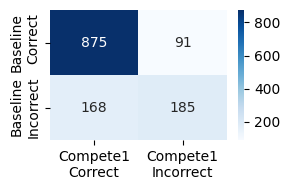

In [63]:
# Extract predictions for baseline and compete1
baseline_predictions = [output['is_correct'] for output in baseline_outputs.values()]
compete1_predictions = [output['is_correct'] for output in compete1_outputs.values()]

# Create confusion matrix
cm = confusion_matrix(baseline_predictions, compete1_predictions, labels=[1, 0])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Compete1\nCorrect', 'Compete1\nIncorrect'],
            yticklabels=['Baseline\nCorrect', 'Baseline\nIncorrect'])

plt.tight_layout()
plt.show()

### Visualize some questions, baseline answered incorrectly but compete1 answered correctly

In [10]:
question_indices_baseline_incorrect_but_compete1_correct = [
    idx for idx, (baseline_output, compete1_output) in enumerate(zip(baseline_outputs.values(), compete1_outputs.values()))
    if not baseline_output['is_correct'] and compete1_output['is_correct']
]

for idx in question_indices_baseline_incorrect_but_compete1_correct[:5]:
    baseline_output = baseline_outputs[idx]
    compete1_output = compete1_outputs[idx]
    print(f"Question {idx}:\n")
    print(f"[Question]: {baseline_output['question']}\n")
    print(f"[Baseline predicted answer]: {baseline_output['predicted_answer']}")
    print(f"[Compete1 predicted answer]: {compete1_output['predicted_answer']}")
    print()

Question 4:

[Question]: Every day, Wendi feeds each of her chickens three cups of mixed chicken feed, containing seeds, mealworms and vegetables to help keep them healthy.  She gives the chickens their feed in three separate meals. In the morning, she gives her flock of chickens 15 cups of feed.  In the afternoon, she gives her chickens another 25 cups of feed.  How many cups of feed does she need to give her chickens in the final meal of the day if the size of Wendi's flock is 20 chickens?

[Baseline predicted answer]: Wendi feeds her chickens a total of 15 cups + 25 cups = <<15+25=40>>40 cups of feed in the morning and afternoon.
Each chicken gets 3 cups of feed per meal, and there are 3 meals per day, so each chicken needs 3 cups/meal * 3 meals/day = <<3*3=9>>9 cups of feed per day.
With 20 chickens, the total amount of feed needed for the day is 20 chickens * 9 cups/chicken = <<20*9=180>>180 cups of feed.
Since Wendi has already given 40 cups of feed in the morning and afternoon, 

### Self-certainty change

Text(0.5, 0, 'Self-Certainty')

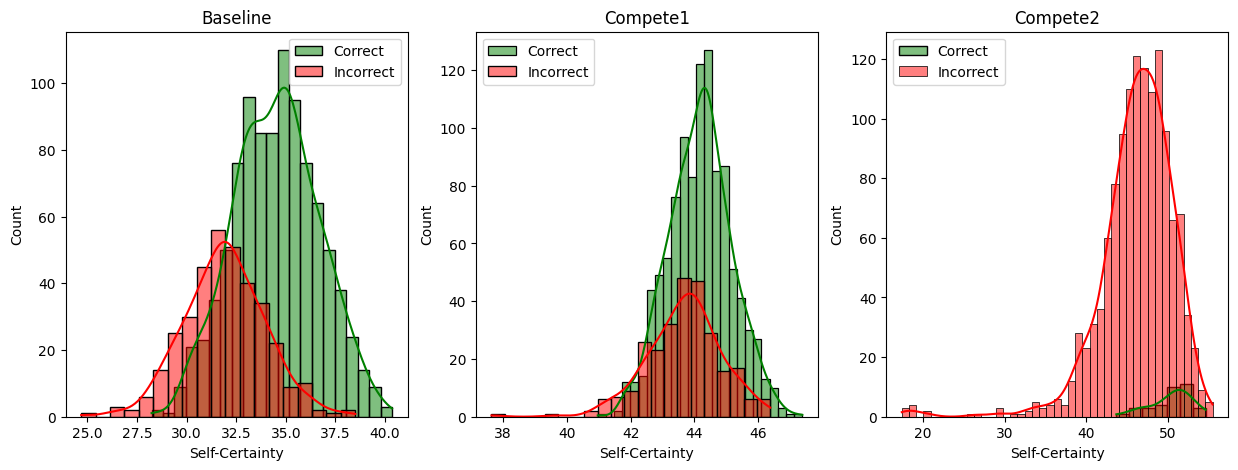

In [48]:
sc_correct_baseline = [output['self_certainty'] for output in baseline_outputs.values() if output['is_correct']]
sc_incorrect_baseline = [output['self_certainty'] for output in baseline_outputs.values() if not output['is_correct']]
sc_correct_compete1 = [output['self_certainty'] for output in compete1_outputs.values() if output['is_correct']]
sc_incorrect_compete1 = [output['self_certainty'] for output in compete1_outputs.values() if not output['is_correct']]
sc_correct_compete2 = [output['self_certainty'] for output in compete2_outputs.values() if output['is_correct']]
sc_incorrect_compete2 = [output['self_certainty'] for output in compete2_outputs.values() if not output['is_correct']]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].set_title("Baseline")
sns.histplot(sc_correct_baseline, color='green', label='Correct', kde=True, ax=axes[0])
sns.histplot(sc_incorrect_baseline, color='red', label='Incorrect', kde=True, ax=axes[0])
axes[0].legend()
axes[0].set_xlabel("Self-Certainty")

axes[1].set_title("Compete1")
sns.histplot(sc_correct_compete1, color='green', label='Correct', kde=True, ax=axes[1])
sns.histplot(sc_incorrect_compete1, color='red', label='Incorrect', kde=True, ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("Self-Certainty")

axes[2].set_title("Compete2")
sns.histplot(sc_correct_compete2, color='green', label='Correct', kde=True, ax=axes[2])
sns.histplot(sc_incorrect_compete2, color='red', label='Incorrect', kde=True, ax=axes[2])
axes[2].legend()
axes[2].set_xlabel("Self-Certainty")